# Praca domowa 5 - klasteryzacja

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Wczytujemy zbiorek

In [9]:
data = pd.read_csv('./../../clustering.csv', header=None)

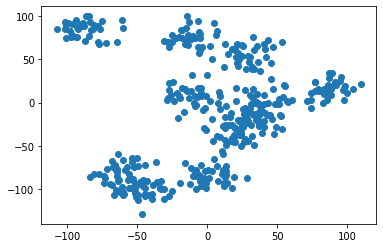

In [21]:
plt.scatter(data.loc[:,0], data.loc[:,1])

Jak ja to potencjalnie widzę?

![image](./klastry.jpg)

Z takiego grupowania na oko, tak właśnie widziałbym podział w zależności od ilości klastrów. Potencjalnie grupy zaznaczone tym samym kolorem możnaby połączyć. Zobaczmy jednak jakie wyniki dają modele klasteryzujące.

## Pierwszy testowany model - KMeans

Zbiór jest na tyle prosty, że algorytm K-średnich powinien poradzić sobie przyzwoicie.

In [50]:
from sklearn.cluster import KMeans
model_1 = KMeans(n_clusters=8, random_state=0).fit(data)

Zobaczmy wstępny wynik

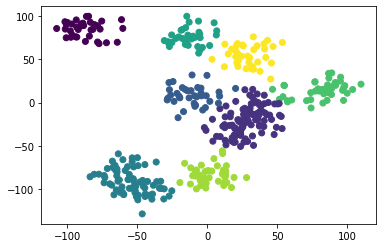

In [77]:
plt.scatter(data.loc[:,0], data.loc[:,1], c=model_1.labels_, marker = 'o')

Jak widać algorytm K-średnich na domyślnych parametrach, wyznaczył dokładnie takie klastry jak ja na pierwszy rzut oka. Sprawdźmy zatem jaką ilość podpowiada nam znana metoda łokcia!

## KMeans i metoda łokcia

Skorzystajmy z gotowej metryki do obliczania odległości punktów wewnątrz klastrów, bo... czemu nie?

In [54]:
def count_wcss_scores(data, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        model = KMeans(n_clusters=k, random_state=0)
        model.fit(data)
        wcss = model.score(data) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

In [58]:
wcss_vec = count_wcss_scores(data, 15) # możemy zrobić i dla 15, nie powinno zająć to dużo czasu

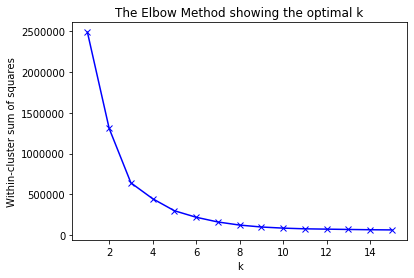

In [59]:
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

I zgodnie z przewidywaniami. Silne wypłaszczenie zaczęło się na k = 5 a kończy na k = 8. Później jest jużpodobnie. Co oznacza, że metoda łokcia sprawdza siętu świetnie. Możemy zobaczyć, że każde z tych doborów k z przedziału [5,8], niesie za sobą jakąś ciekawą informację i ma sens.

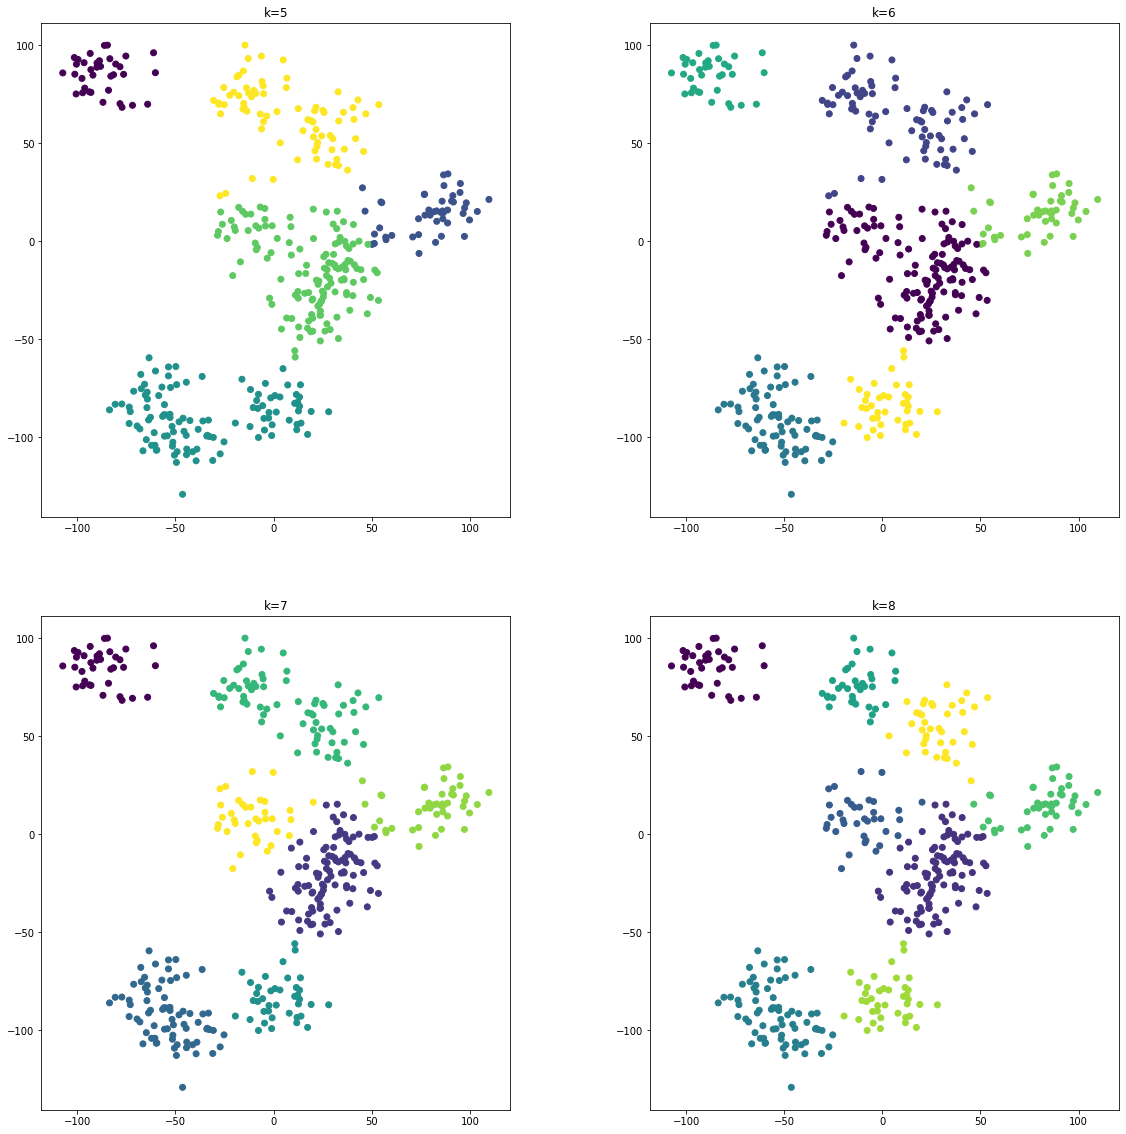

In [106]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for k in range(5, 9):
    model = KMeans(n_clusters=k, random_state=0).fit(data)
    i, j = (k-1)//2%2, (k-1)%2
    axes[i][j].scatter(data.loc[:,0], data.loc[:,1], c=model.labels_, marker = 'o')
    axes[i][j].set(aspect = 'equal')
    axes[i][j].set_title('k=' + str(k))

Jak widzimy każdy z tych podziałów zachowuje swój własny sens. Ciężko powiedzieć, że któryś jest dobry albo zły. Myślę, że przy danych dwuwymiarowych często spotyka się takie sytuacje.

## Drugi model - klastrowanie aglomeracyjne

Sprawdźmy jak radzi sobie nieco bardziej zaawansowana metoda, taka jak AgglomerativeClustering

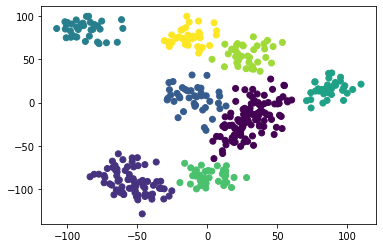

In [109]:
from sklearn.cluster import AgglomerativeClustering
model_2 = AgglomerativeClustering(n_clusters=8).fit(data)
plt.scatter(data.loc[:,0], data.loc[:,1], c=model_2.labels_, marker = 'o')
# domyślna metoda 'ward' minimalizuję wariancję między potencjalnie łączonymi klastrami

Wstępny wynik jest bardzo podobny, chociaż można odnieść wrażenie, że podział jest "gładszy"(tzn. nie ma wyraźnych linii cięć pomiędzy grupami).

## Szukanie ilości klastrów metodą silhouette'a

Tutaj oczywiście też skorzystam z funkcji pisanych na laboratoriach.

In [110]:
def count_clustering_scores(data, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(data)
        wcss = score_fun(data, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

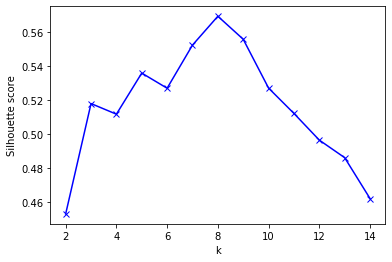

In [112]:
from sklearn.metrics import silhouette_score

cluster_num_seq = range(2, 15)
silhouette_vec = count_clustering_scores(data, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

Zgodnie z metryką silhouette, dobrze trafiono z użyciem 8 klastrów, ale wysoko punktuje też użycia 7 i 9. Spójrzmy na wykresy.

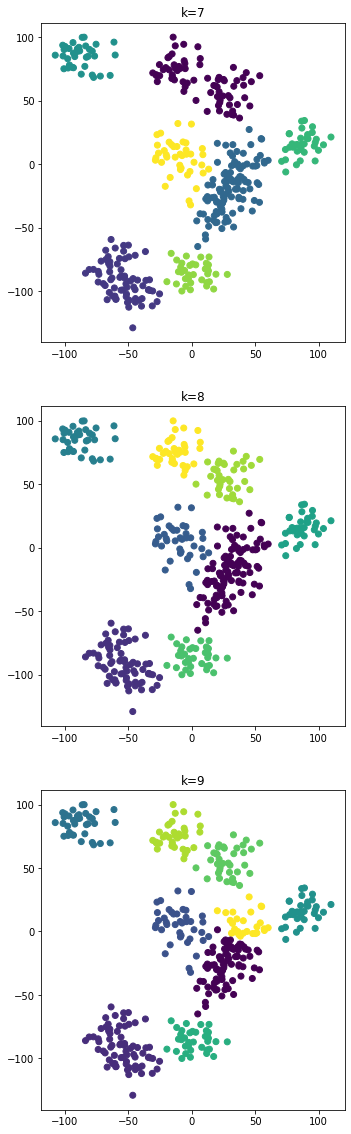

In [115]:
fig, axes = plt.subplots(3, figsize=(20, 20))
for k in range(7, 10):
    model = AgglomerativeClustering(n_clusters=k).fit(data)
    i = k-7
    axes[i].scatter(data.loc[:,0], data.loc[:,1], c=model.labels_, marker = 'o')
    axes[i].set(aspect = 'equal')
    axes[i].set_title('k=' + str(k))

Wyniki dla 7 i 8 jak najbardziej mają sens. Dla 9 mam już pewne obiekcje. Wiele jest punktów żółtych, będących blisko skupienia fioletowych.

## Wstępne obserwacje

Ciężko wiele powiedzieć, o metodach wyznaczania ilości klastrów jak i algorytmów, mająć do czynienia z tak małą ilością testów. Jeśli chodzi o wyznaczanie optymalnego k to:  
- metoda łokcia jest bardzo niejednoznaczna, ale za to daje nam obraz tego w jakim zakresie k powinniśmy się pochylić.  
- metoda silhouette daje nam już bardziej sprecyzowany wynik jednego k, którego powinniśmy użyć.  

Dalej algorytmy:  

- KMeans, jest dość intuicyjny ale też naiwny. Łatwo przewidzieć jakie da nam wyniki. Niestety mało adaptuje się do zbioru i po podziale można zaobserwować, linie po których zbiór został podzielony.
- Klastrowanie aglomeracyjne daje nieco schludniejsze i bardziej dopasowane rezultaty. Na pewno sprawdzi się lepiej od KMeans w przypadkach gdy klastry będę bardzo blisko siebie.